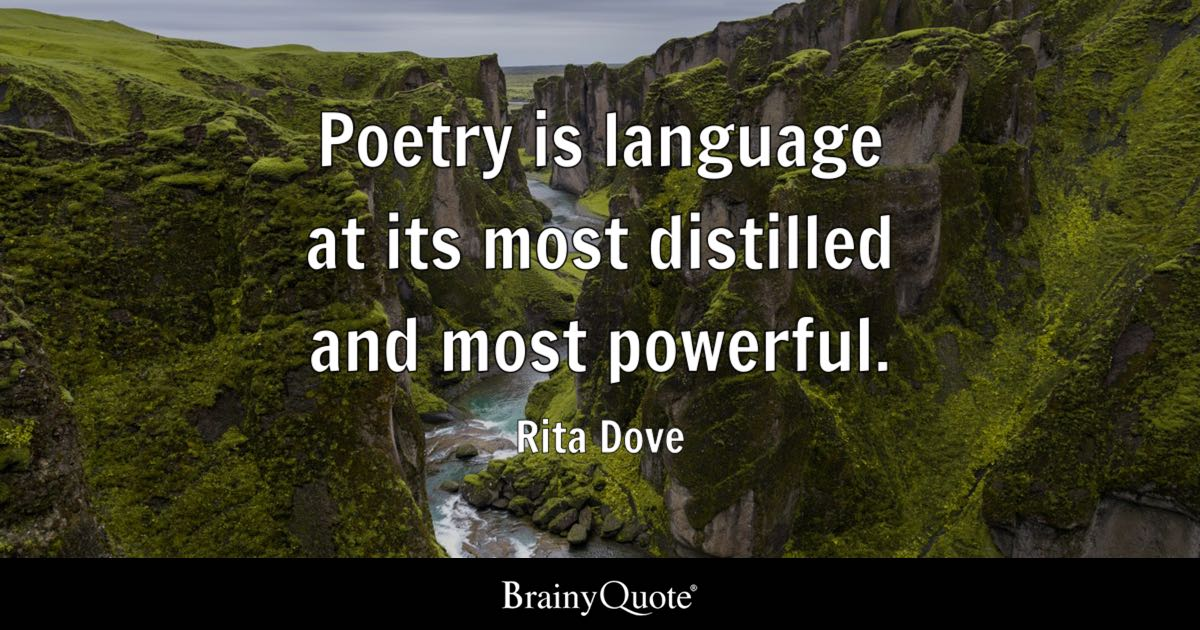

In [74]:
import tensorflow as tf
import numpy as np
import os

In [75]:
path="/content/Sonnets.txt"
text = open(path, 'r')
file = text.read()
print(file)

From fairest creatures we desire increase,
That thereby beauty's rose might never die,
But as the riper should by time decease,
His tender heir might bear his memory:
But thou contracted to thine own bright eyes,
Feed'st thy light's flame with self-substantial fuel,
Making a famine where abundance lies,
Thy self thy foe, to thy sweet self too cruel:
Thou that art now the world's fresh ornament,
And only herald to the gaudy spring,
Within thine own bud buriest thy content,
And, tender churl, mak'st waste in niggarding:
Pity the world, or else this glutton be,
To eat the world's due, by the grave and thee.

When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy

In [76]:
text = open(path, 'rb').read()
text = text.decode(encoding='utf-8')
print('Total number of characters is:', len(text))
print('The first 100 characters are as follows:\n', text[:100])

Total number of characters is: 96390
The first 100 characters are as follows:
 From fairest creatures we desire increase,
That thereby beauty's rose might never die,
But as the 


## Vectorization of Text

Text Vectorization is the process of converting text into numerical representation.

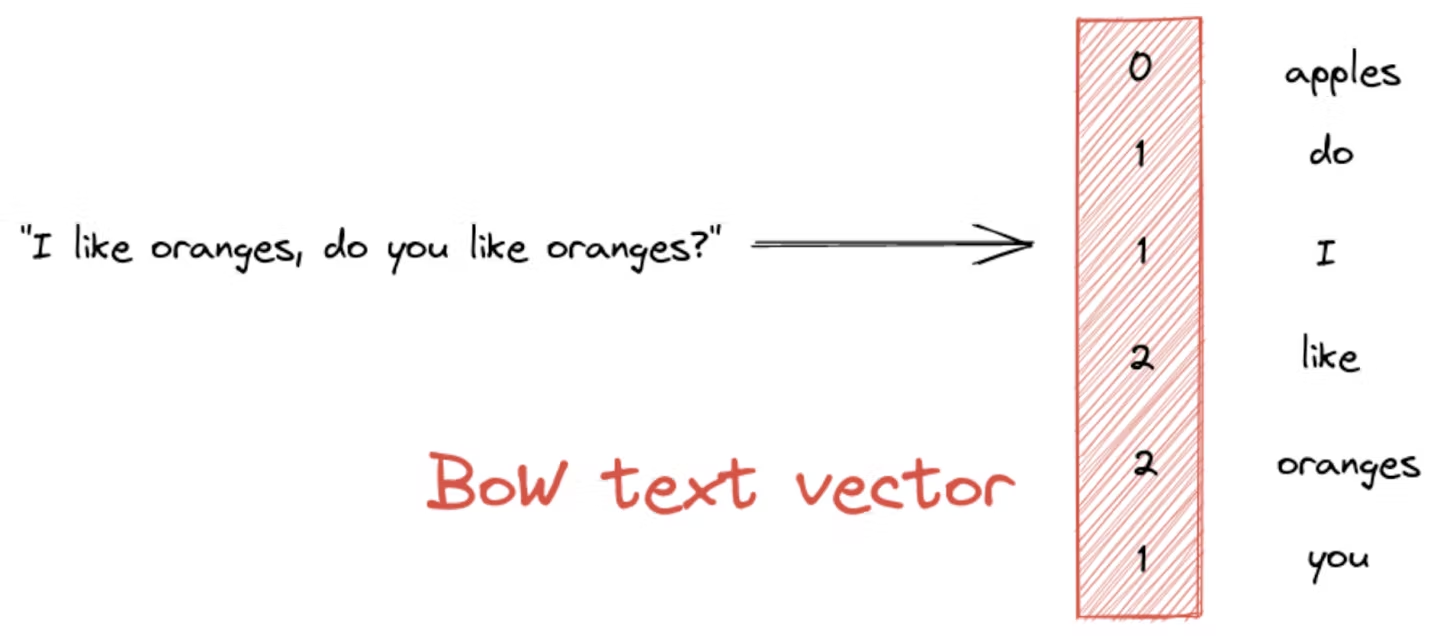

In [77]:
vocab = sorted(set(text))
print ('The number of unique characters in the corpus is', len(vocab))

The number of unique characters in the corpus is 62


In [78]:
char2idx = {u:i for i, u in enumerate(vocab)}
print(char2idx)

{'\n': 0, '\r': 1, ' ': 2, '!': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'R': 29, 'S': 30, 'T': 31, 'U': 32, 'V': 33, 'W': 34, 'Y': 35, 'a': 36, 'b': 37, 'c': 38, 'd': 39, 'e': 40, 'f': 41, 'g': 42, 'h': 43, 'i': 44, 'j': 45, 'k': 46, 'l': 47, 'm': 48, 'n': 49, 'o': 50, 'p': 51, 'q': 52, 'r': 53, 's': 54, 't': 55, 'u': 56, 'v': 57, 'w': 58, 'x': 59, 'y': 60, 'z': 61}


In [79]:
idx2char = np.array(vocab)
print(idx2char)

['\n' '\r' ' ' '!' "'" '(' ')' ',' '-' '.' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'R' 'S' 'T' 'U' 'V' 'W' 'Y'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [80]:
text_as_int = np.array([char2idx[c] for c in text])

In [81]:
print(text_as_int)

[18 53 50 ... 57 40  9]


With the help of tf.data.Dataset.from_tensor_slices() method, we can get the slices of an array in the form of objects by using tf.data.Dataset.from_tensor_slices() method.

In [82]:
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int) 
seq_length = 100
sequences = char_dataset.batch(seq_length+1, drop_remainder=True) 

In [83]:
for item in sequences.take(5): 
   print(repr(''.join(idx2char[item.numpy()])))

"From fairest creatures we desire increase,\r\nThat thereby beauty's rose might never die,\r\nBut as the r"
'iper should by time decease,\r\nHis tender heir might bear his memory:\r\nBut thou contracted to thine ow'
"n bright eyes,\r\nFeed'st thy light's flame with self-substantial fuel,\r\nMaking a famine where abundanc"
"e lies,\r\nThy self thy foe, to thy sweet self too cruel:\r\nThou that art now the world's fresh ornament"
',\r\nAnd only herald to the gaudy spring,\r\nWithin thine own bud buriest thy content,\r\nAnd, tender churl'


In [84]:
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

dataset = sequences.map(split_input_target)

In [85]:
"""for i in dataset.take(5):
  print(i)"""

'for i in dataset.take(5):\n  print(i)'

We generate the tuples because it is necessary for RNN to work on

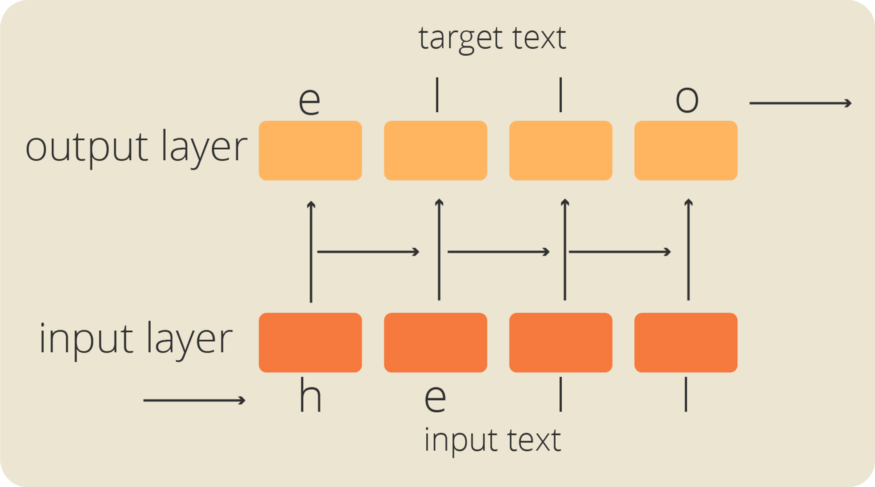

In [86]:
BUFFER_SIZE = 10000

BATCH_SIZE = 64 

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>


## Building the Model

In [87]:
vocab_size = len(vocab)

embedding_dim = 256

rnn_units = 1024

There are three layers in our model:

- An Embedding Layer: This layer serves as the input layer, accepting input values (in number format) and convert them into vectors.
- A GRU layer: An RNN layer filled with 1024 Gradient Descent Units
- A Dense layer: To output the result, with vocab_size outputs.

In [88]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

We had set the batch_size earlier to 64 as our output is always one of the 65 characters

In [89]:
model = build_model(
    vocab_size = len(vocab), 
    embedding_dim=embedding_dim, 
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE) 

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (64, None, 256)           15872     
                                                                 
 gru_6 (GRU)                 (64, None, 1024)          3938304   
                                                                 
 dense_6 (Dense)             (64, None, 62)            63550     
                                                                 
Total params: 4,017,726
Trainable params: 4,017,726
Non-trainable params: 0
_________________________________________________________________


In [90]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
model.compile(optimizer='adam', loss=loss)

In [91]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [92]:
EPOCHS = 50
history = model.fit(dataset, 
                    epochs=EPOCHS, 
                    callbacks=[checkpoint_callback])

Epoch 1/50
14/14 [==============================] - 2s 65ms/step - loss: 3.9836
Epoch 2/50
14/14 [==============================] - 1s 63ms/step - loss: 3.2102
Epoch 3/50
14/14 [==============================] - 1s 62ms/step - loss: 2.8347
Epoch 4/50
14/14 [==============================] - 1s 62ms/step - loss: 2.5357
Epoch 5/50
14/14 [==============================] - 1s 62ms/step - loss: 2.3445
Epoch 6/50
14/14 [==============================] - 1s 75ms/step - loss: 2.2459
Epoch 7/50
14/14 [==============================] - 1s 61ms/step - loss: 2.1883
Epoch 8/50
14/14 [==============================] - 1s 61ms/step - loss: 2.1496
Epoch 9/50
14/14 [==============================] - 1s 62ms/step - loss: 2.1109
Epoch 10/50
14/14 [==============================] - 1s 61ms/step - loss: 2.0782
Epoch 11/50
14/14 [==============================] - 1s 64ms/step - loss: 2.0422
Epoch 12/50
14/14 [==============================] - 1s 63ms/step - loss: 2.0081
Epoch 13/50
14/14 [==================

In [93]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_50'

In [94]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (1, None, 256)            15872     
                                                                 
 gru_7 (GRU)                 (1, None, 1024)           3938304   
                                                                 
 dense_7 (Dense)             (1, None, 62)             63550     
                                                                 
Total params: 4,017,726
Trainable params: 4,017,726
Non-trainable params: 0
_________________________________________________________________


We need is a custom function to prepare our input for the model.

In [95]:
def generate_text(model, num_generate, temperature, start_string):
  input_eval = [char2idx[s] for s in start_string] 
  input_eval = tf.expand_dims(input_eval, 0) 
  text_generated = [] 
  model.reset_states() 

  for i in range(num_generate): 
    predictions = model(input_eval) 
    predictions = tf.squeeze(predictions, 0) 
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
    input_eval = tf.expand_dims([predicted_id], 0) 
    text_generated.append(idx2char[predicted_id]) 

  return (start_string + ''.join(text_generated))

In [96]:
generated_text = generate_text(
                    model, 
                    num_generate=500, 
                    temperature=1, 
                    start_string=u"ROMEO")
print(generated_text)

ROMEOs,
Makes blamate in this advantage found,
Unot for form of well-fully ow that prove
Make survestance at all unoned his beauty my deems to cossoling,
A bender me than time,
Or alt, find where thou art forsworn,
 to be subjects,
And when from heals tocted,
Didy to my limeness cherity hers mistress'd thy beauty thy shalough the base,
Which, like Eeauties of Time dubbost shade
If thy deep kind,
Doon to
But which no fach as forfeNat of his gentle gay:
That in ghest my glass shows not love
